In [96]:
from nutils import *
import numpy, unittest

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections

In [113]:
nelems = 1
degree = 0
tol    = 1e-5
ndims  = 1
h = 1.0 / nelems

In [114]:
domain, geom = mesh.rectilinear([numpy.linspace(0,1,nelems+1)]*ndims)

In [118]:
# prepare residual
ns = function.Namespace()
ns.pi = numpy.pi
ns.x = geom
ns.h = h


# construct bases
ns.alpha, ns.beta = function.chain([
    domain.basis( 'std', degree=degree+1),
    domain.basis( 'discont', degree=degree),
])

# solution variables
ns.phi = 'alpha_n ?lhs_n'
ns.u   = 'beta_n ?lhs_n'

# Peclet number
ns.Pe = 50

# supg stabilization parameter
ns.pe = '0.5 Pe h'
ns.xi = '(cosh(pe) / sinh(pe)) - (1 / pe)'
ns.tau = '(h / (2 Pe)) xi'

# analytical solution and forcing vector
ns.pi  = numpy.pi

ns.g   = '(1 / (1 - exp(Pe))) (exp(Pe x_0) - 1) + x_0'
ns.dg  = '(Pe / (1 - exp(Pe))) exp(Pe x_0) + 1'
ns.ddg  = '((Pe)^2 / (1 - exp(Pe))) exp(Pe x_0)'

# ns.g   = '1 + ((exp(Pe x_0) - 1) / ( 1 - exp(Pe)))'
# ns.dg  = '-(  Pe    exp(Pe x_0 )) / (exp(Pe) - 1)'
# ns.ddg = '-( (Pe)^2 exp(Pe x_0 )) / (exp(Pe) - 1)'

# ns.z = 1.5
# ns.g  = 'cos( z pi x_0 )'
# ns.dg = '-(z pi) sin( z pi x_0 )'
# ns.ddg = '-(z pi)^2 cos( z pi x_0 )'

ns.f   = ' - ddg + Pe dg'

# print the Peclet number
print('The Peclet number is: ',ns.Pe.eval()[0])
print('The stabilization parameter is: ',ns.xi.eval()[0])

The Peclet number is:  50
The stabilization parameter is:  0.96


In [119]:
# construct residual and inertia vector
res = domain.integral('- alpha_m,0 u - alpha_m phi' @ ns, geometry=ns.x, degree=degree*2)

# construct residual and inertia vector
res += domain.integral('beta_n ( - phi_,0 + Pe u_,0 - f )' @ ns, geometry=ns.x, degree=degree*2)

# boundary integral
res += domain.boundary.integral('alpha_m g n_0' @ ns, geometry=ns.x, degree=degree*2)

# supg term
# res += domain.integral('alpha_m ( - phi + u_,0 )' @ ns, geometry=ns.x, degree=degree*2)
res += domain.integral('tau Pe beta_n,0 ( - u_,00 + Pe u_,0 - f )' @ ns, geometry=ns.x, degree=degree*2)


solve > solver returned with residual 0e+00
L2 error: 5.00e-01


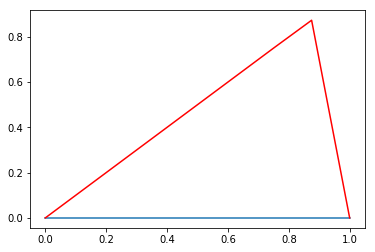

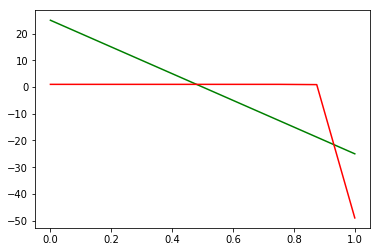

In [120]:
# find lhs such that res == 0 and substitute this lhs in the namespace
lhs = solver.solve_linear('lhs', res)
ns = ns(lhs=lhs)

# plot solution
plt.figure()
bezier = domain.sample('bezier', 9)
x, u = bezier.eval([ns.x, ns.u])
x, g = bezier.eval([ns.x, ns.g])
plt.plot(x, u)
plt.plot(x, g, 'r')

# plot solution
plt.figure()
bezier = domain.sample('bezier', 9)
x, phi = bezier.eval([ns.x, ns.phi])
x, dg = bezier.eval([ns.x, ns.dg])
plt.plot(x, phi, 'g')
plt.plot(x, dg, 'r')

# evaluate error against exact solution fx fy
err = domain.integrate('(u - g)^2' @ ns, geometry=ns.x, degree=degree*2)**.5
log.user('L2 error: {:.2e}'.format(err))